![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


filename_features = "Dados/UCI HAR Dataset/features.txt"
filename_labels = "Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, usecols=[1], names = ['colunas'], sep= ' ')
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace = True, header=None)
X_train.columns = features['colunas'].tolist()
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)
X_test.columns = features['colunas'].tolist()
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

#### Análises de componentes principais para a base do HAR - com padronização

In [2]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 484 ms
Wall time: 571 ms


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [3]:
# Gerando as componentes principais
prcomp = PCA().fit(X_train_pad)

n_componentes = X_train_pad.shape[1]

pc_treino_pad = prcomp.transform(X_train_pad)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf = pd.DataFrame(data = pc_treino_pad
             , columns = nomes_pca)

In [4]:
# Visualizando o DataFrame com as componentes principais
principalDf.head()

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,7.463840e-17,1.404601e-15,-4.781994e-16,3.444081e-16,-6.231900e-16,2.664176e-16,-8.416061e-16,1.798216e-16,1.517177e-15,6.404244e-15
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,4.609387e-17,2.106263e-16,5.051019e-16,3.951819e-17,2.260087e-16,4.121135e-16,-9.683150e-17,1.007567e-16,4.574440e-17,-1.402720e-15
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-1.511061e-16,1.028987e-16,-1.867799e-16,-2.360923e-16,6.112837e-16,9.308254e-17,-1.682728e-17,8.823363e-17,-1.658976e-15,-5.195643e-15
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,1.723059e-16,6.775566e-16,-2.819722e-16,-3.012859e-16,-4.992920e-17,6.946782e-17,9.940112e-17,2.077313e-16,-3.003400e-16,7.872161e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-3.963818e-16,1.402981e-16,3.667918e-16,-3.525148e-16,4.839891e-16,7.403944e-16,1.077464e-16,3.524336e-17,-4.334081e-16,-4.222735e-15


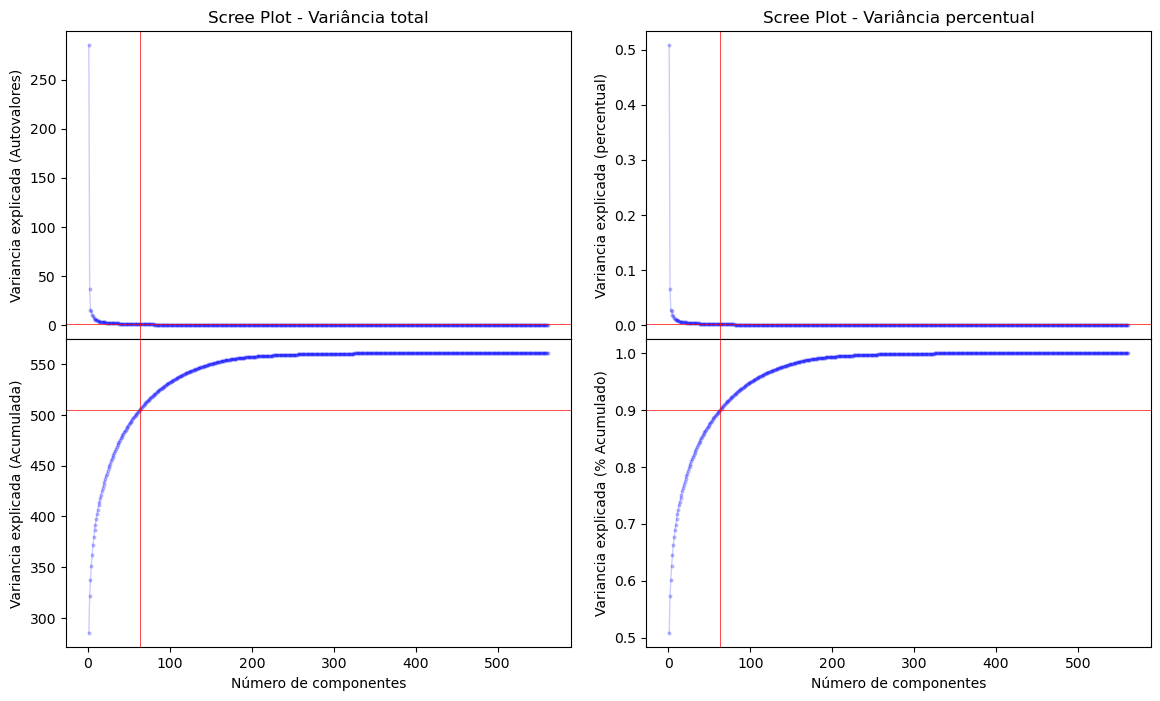

In [5]:
# Visualização gráfica
# A variância explicada por componente
# A variância explicada acumulada por componente
# A variância percentual por componente
# A variância percentual acumulada por componente
# Quantas componentes para explicar 90% da variância

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .90
ncomp_criterio3 = (prcomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [6]:
# Quantidade de componentes para explicar 90% da variância
ncomp_criterio3

63

In [7]:
# Visualizando os valores da variância explicativa acumulada
prcomp.explained_variance_ratio_.cumsum()

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569,
       0.7167562 , 0.72475901, 0.73239898, 0.73885227, 0.74517551,
       0.75117273, 0.75704023, 0.76279431, 0.76847352, 0.77374648,
       0.77875011, 0.78363419, 0.78841625, 0.79310188, 0.79759477,
       0.80180504, 0.80598483, 0.81004053, 0.81392577, 0.81779595,
       0.82145554, 0.82500108, 0.8284805 , 0.83185237, 0.83514914,
       0.83843129, 0.84163659, 0.84459274, 0.84745996, 0.85031071,
       0.85299837, 0.85565457, 0.85828863, 0.86087714, 0.86336768,
       0.86583722, 0.86824402, 0.87060517, 0.87290796, 0.87518364,
       0.87738528, 0.87951995, 0.881597  , 0.88362196, 0.88561976,
       0.88759726, 0.88954   , 0.89144237, 0.89332302, 0.89518518,
       0.89699985, 0.89877366, 0.90053451, 0.90226735, 0.90397473,
       0.90566021, 0.90731636, 0.90894738, 0.91053175, 0.91210673,
       0.91363696, 0.91515901, 0.9166404 , 0.91810111, 0.91954

#### Análises de componentes principais para a base do HAR - sem padronização

In [8]:
# Gerando as componentes principais
prcomp2 = PCA().fit(X_train)

n_componentes = X_train.shape[1]

pc_treino = prcomp2.transform(X_train)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf2 = pd.DataFrame(data = pc_treino
             , columns = nomes_pca)

In [9]:
# Visualizando o DataFrame com as componentes principais
principalDf2.head()

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,-6.922643e-19,-1.700183e-16,-2.218851e-16,1.412575e-16,4.116624e-17,-1.531676e-16,1.222737e-15,3.611804e-17,2.009304e-17,2.955049e-17
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-1.439789e-17,-6.865424e-18,-2.583876e-16,2.069710e-17,4.682698e-17,-6.273172e-16,-2.241039e-16,5.279344e-17,1.502126e-16,2.387264e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-4.111373e-18,4.717459e-17,-1.515091e-16,6.485891e-18,4.048619e-17,1.891104e-17,1.052828e-15,-1.523757e-17,8.300405e-17,8.144434e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,-1.661319e-16,6.553197e-18,-1.747703e-16,3.465223e-17,6.703025e-18,1.296476e-16,-1.280101e-16,-2.814123e-16,-9.269968e-17,1.237920e-16
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-5.199952e-17,2.089456e-17,-1.858470e-16,3.160710e-17,-1.291358e-16,-1.605630e-16,3.319121e-17,1.844928e-16,8.214798e-18,2.389635e-16


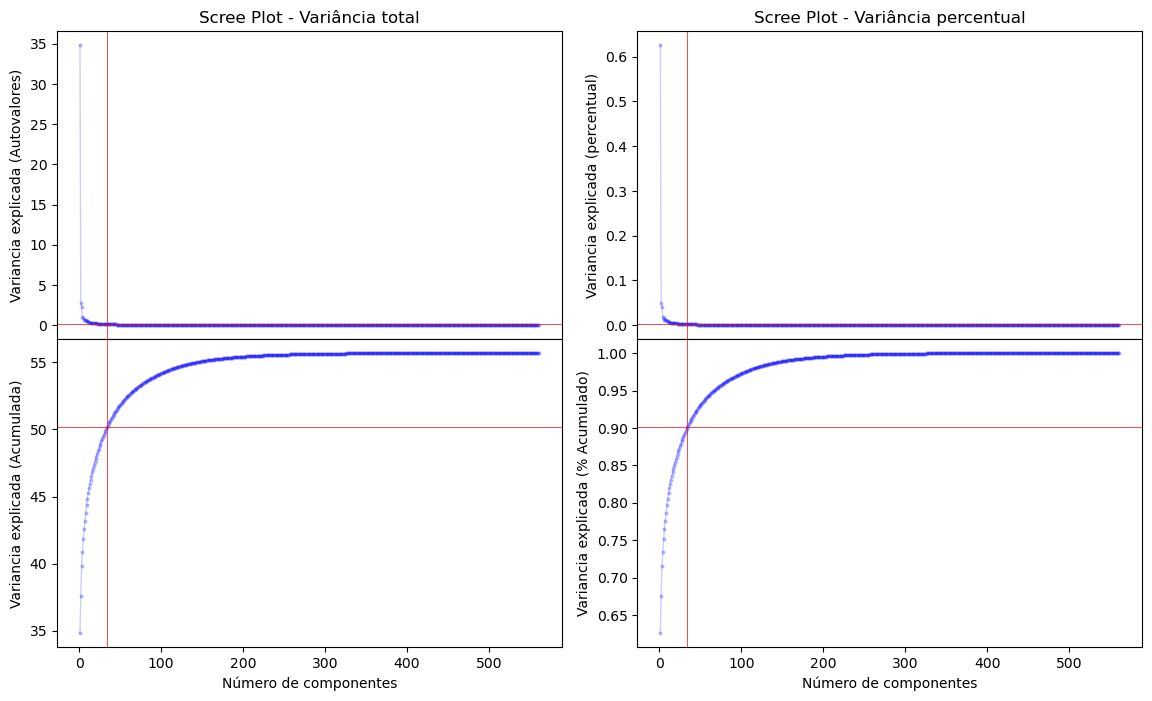

In [10]:
# Visualização gráfica
# A variância explicada por componente
# A variância explicada acumulada por componente
# A variância percentual por componente
# A variância percentual acumulada por componente
# Quantas componentes para explicar 90% da variância

fig2, ax2 = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .90
ncomp_criterio3_2 = (prcomp2.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp2.n_components_) + 1
ax2[0,0].plot(num_componentes, prcomp2.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax2[0,0].set_title('Scree Plot - Variância total')
ax2[0,0].set_xlabel('Número de componentes')
ax2[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax2[1,0].plot(num_componentes, prcomp2.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax2[1,0].set_xlabel('Número de componentes')
ax2[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax2[0,1].plot(num_componentes, prcomp2.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax2[0,1].set_title('Scree Plot - Variância percentual')
ax2[0,1].set_xlabel('Número de componentes')
ax2[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax2[1,1].plot(num_componentes, prcomp2.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax2[1,1].set_xlabel('Número de componentes')
ax2[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax2[0,0].axvline(x = ncomp_criterio3_2, color = 'r', linestyle = '-', linewidth=.5)
ax2[1,1].axvline(x = ncomp_criterio3_2, color = 'r', linestyle = '-', linewidth=.5)
ax2[1,0].axvline(x = ncomp_criterio3_2, color = 'r', linestyle = '-', linewidth=.5)
ax2[0,1].axvline(x = ncomp_criterio3_2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax2[0,0].axhline(y = prcomp2.explained_variance_[ncomp_criterio3_2-1], color = 'r', linestyle = '-', linewidth=.5)
ax2[1,0].axhline(y = prcomp2.explained_variance_.cumsum()[ncomp_criterio3_2-1], color = 'r', linestyle = '-', linewidth=.5)
ax2[0,1].axhline(y = prcomp2.explained_variance_ratio_[ncomp_criterio3_2-1], color = 'r', linestyle = '-', linewidth=.5)
ax2[1,1].axhline(y = prcomp2.explained_variance_ratio_.cumsum()[ncomp_criterio3_2-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [12]:
# Quantidade de componentes para explicar 90% da variância
ncomp_criterio3_2

34

In [13]:
# Visualizando os valores da variância explicativa acumulada
prcomp2.explained_variance_ratio_.cumsum()

array([0.6255444 , 0.67467463, 0.7158893 , 0.73463886, 0.75158746,
       0.76430816, 0.77607501, 0.78676474, 0.79645854, 0.80503872,
       0.81266174, 0.81938619, 0.82518039, 0.8307592 , 0.83574845,
       0.84049783, 0.84516983, 0.84948601, 0.85374316, 0.85784711,
       0.86178714, 0.86554023, 0.8690645 , 0.8724581 , 0.87577949,
       0.87897378, 0.88199157, 0.88490939, 0.88780509, 0.89062437,
       0.89339141, 0.89602536, 0.89857843, 0.90093709, 0.90324361,
       0.90548009, 0.90770957, 0.90981233, 0.91189626, 0.913944  ,
       0.91587257, 0.91776136, 0.91957316, 0.92136789, 0.92309117,
       0.92469319, 0.92626358, 0.92782986, 0.92935955, 0.93086307,
       0.93231424, 0.93372065, 0.9350889 , 0.93635748, 0.93760754,
       0.93880496, 0.93998616, 0.94113611, 0.94226693, 0.94336363,
       0.94444067, 0.94548967, 0.94652861, 0.94754335, 0.94853487,
       0.94950512, 0.95045922, 0.95137385, 0.95226151, 0.95313752,
       0.95399025, 0.95481929, 0.95564105, 0.95644739, 0.95722

**Comparação:**
- Diferente do esperado, a padronização das variáveis **não apresentou melhora nos resultados**, tendo a primeira caído de **62,55%** para **50,78%** na variância explicativa acumulada. Também houve **aumento no número de componentes** necessárias para explicar 90% de variância. É possível também observar uma mudança na escala após a aplicação da padronização.

## Árvore com PCA

Faça duas árvores de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

#### Análises de componentes principais para a base do HAR - com padronização

In [15]:
%%time
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

prcomp3 = PCA(n_components=10).fit(X_train_pad)

pc_treino_pad = prcomp3.transform(X_train_pad)
pc_teste_pad  = prcomp3.transform(X_test_pad)

clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=0.001).fit(pc_treino_pad, y_train)
print(f"R_quadrado na base de treino: {clf.score(pc_treino_pad, y_train)*100:.2f}")
print(f"R_quadrado na base de teste: {clf.score(pc_teste_pad, y_test)*100:.2f}")

R_quadrado na base de treino: 85.87
R_quadrado na base de teste: 77.40
CPU times: total: 2.55 s
Wall time: 1.2 s


#### Análises de componentes principais para a base do HAR - sem padronização

In [16]:
%%time
prcomp4 = PCA(n_components=10).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

clf2 = DecisionTreeClassifier(random_state=2360873, ccp_alpha=0.001).fit(pc_treino, y_train)
print(f"R_quadrado na base de treino: {clf2.score(pc_treino, y_train)*100:.2f}")
print(f"R_quadrado na base de teste: {clf2.score(pc_teste, y_test)*100:.2f}")

R_quadrado na base de treino: 87.84
R_quadrado na base de teste: 80.86
CPU times: total: 2.19 s
Wall time: 720 ms


**Comparação:**
- Após aplicação da padronização das variáveis é possível observar uma pequena redução na acurária obtida na árvore de decisão, tanto na base de treino quanto na base de teste.
